<a href="https://colab.research.google.com/github/H40Q1/523_stock_predict/blob/main/main_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EC523 Project : Stock Price Prediction

##  0. Import Libraries

In [46]:
!pip3 install pytorch-nlp
import pandas as pd
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torchnlp.nn as nlpnn

##  1. Data Preprocess

First of all, let's read the data set file and take a look of it.

In [47]:
path = "/content/stock_data.csv"
stock_dataset =  pd.read_csv(path, header=0)

Let's take a look of first 5 rows of data set.

In [48]:
stock_dataset.head()

,index_code,date,open,close,low,high,volume,money,change
0,sh000001,1990/12/20,104.30,104.39,99.98,104.39,197000.0,85000.0,0.044109
1,sh000001,1990/12/21,109.07,109.13,103.73,109.13,28000.0,16100.0,0.045407
2,sh000001,1990/12/24,113.57,114.55,109.13,114.55,32000.0,31100.0,0.049666
3,sh000001,1990/12/25,120.09,120.25,114.55,120.25,15000.0,6500.0,0.049760
4,sh000001,1990/12/26,125.27,125.27,120.25,125.27,100000.0,53700.0,0.041746


In [49]:
stock_dataset.describe()

,open,close,low,high,volume,money,change
count,6109.000000,6109.000000,6109.000000,6109.000000,6.109000e+03,6.109000e+03,6109.000000
mean,1774.168370,1775.191989,1753.858407,1792.686525,2.258868e+10,6.013645e+10,0.000882
std,1047.920798,1049.208658,1033.753364,1060.291179,3.635068e+10,1.253975e+11,0.026197
min,104.300000,104.390000,99.980000,104.390000,1.500000e+04,6.500000e+03,-0.163937
25%,1100.690000,1101.490000,1087.850000,1112.100000,3.634716e+09,3.157918e+09,-0.007923
50%,1570.650000,1570.700000,1556.530000,1583.760000,8.551797e+09,9.848770e+09,0.000701
75%,2293.810000,2295.950000,2278.160000,2312.560000,1.970836e+10,7.762494e+10,0.009374
max,6057.430000,6092.060000,6040.710000,6124.040000,2.760000e+11,1.310000e+12,1.052691


What is the exact length of each column?

In [50]:
open_price = stock_dataset.open.values.astype('float32')
open_price = open_price.reshape(-1, 1)
print(open_price.shape[0])

6109


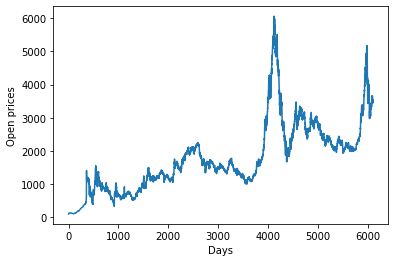

In [51]:
plt.plot(open_price)
plt.ylabel("Open prices")
plt.xlabel("Days")
plt.show()

Here is the class of parameters of this project:

In [53]:
class Config:
    
    feature_columns = list(range(2, 9))     # feature columns' indecies 
    label_columns = [2,3]                # predicted feature columns' indecies
    label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(feature_columns, label_columns)  
    
    predict_day = 1             # predited length (days)
    
    input_size = len(feature_columns)
    output_size = len(label_columns)

    hidden_size = 128           # hiddent size
    lstm_layers = 2             # stacked layer number
    dropout_rate = 0.2          # dropout
    time_step = 20              # step size (day)
    epoch = 50
    epoch_attention = 50
    
#     do_train = True
#     do_predict = True
#     shuffle_train_data = True           

    train_data_rate = 0.7      
    valid_data_rate = 0.15   
    test_data_rate = 0.15

    batch_size = 64
    learning_rate = 0.0001

    use_cuda = False
    # path
    used_frame = "pytorch"
    model_name = "model_" + ".pth"
    train_data_path = "/content/stock_data.csv"
    model_save_path = "./checkpoint/" + used_frame + "/"
    

    # save 
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)    


Class of dataset process and split.

In [52]:
class Data:
    def __init__(self, config):
        self.config = config
        self.data, self.data_column_name = self.read_data()
        self.data = np.array(self.data, dtype=np.float64)
        self.data_num = self.data.shape[0]
        ### interval of dataset
        # x_train [0:s]
        # y_train [d:s+d]
        # x_valid [s:v]
        # y_valid [s+d:v+d]
        # x_test [v:-d]
        # y_test [v+d:-1]

        self.train_num = int(self.data_num * self.config.train_data_rate)   #  self.train_num = s
        
        self.valid_num = int(self.train_num + self.data_num * self.config.valid_data_rate)  # self.valid_num = v
        
        self.mean = np.mean(self.data, axis=0)              # mean and std
        self.std = np.std(self.data, axis=0)
        self.norm_data = (self.data - self.mean)/self.std   # normalization


    def read_data(self):                # read data
        init_data = pd.read_csv(self.config.train_data_path, usecols=self.config.feature_columns)
        
        
        return init_data.values, init_data.columns.tolist()     

    
    def get_train_data(self):
        feature_data = self.norm_data[:self.train_num]  # interval [0:s]  
        
        # interval [d:s+d]  
        label_data = self.norm_data[self.config.predict_day : self.config.predict_day + self.train_num,
                                    self.config.label_in_feature_index]    

        train_x = [feature_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        train_y = [label_data[i:i+self.config.time_step] for i in range(self.train_num-self.config.time_step)]
        

        train_x, train_y = np.array(train_x), np.array(train_y)

        return train_x, train_y
    
    def get_valid_data(self):
        
        feature_data = self.norm_data[self.train_num : self.valid_num]  
        # interval [s:v]  
        
        # interval [s+d:v+d]  
        label_data = self.norm_data[self.config.predict_day + self.train_num : self.config.predict_day + self.valid_num,
                                    self.config.label_in_feature_index]    # create label
        
        
        valid_x = [feature_data[i:i+self.config.time_step] for i in range(self.valid_num-self.train_num-self.config.time_step)]
        valid_y = [label_data[i:i+self.config.time_step] for i in range(self.valid_num-self.train_num-self.config.time_step)]

   
        valid_x, valid_y = np.array(valid_x), np.array(valid_y)

        return valid_x, valid_y


    def get_test_data(self):
        
        feature_data = self.norm_data[self.valid_num :]  
        # feature interval[v:-d]
        
        test_x = [feature_data[i:i+self.config.time_step] for i in range(self.data_num - self.valid_num - self.config.time_step-1)]

        test_x = np.array(test_x)
        
        return test_x
    
    
    def return_label(self, dataset):
        
        if dataset =="train":
            label_data = self.data[self.config.time_step :self.train_num ,
                                            self.config.label_in_feature_index]
        elif dataset == "valid":
            label_data = self.data[self.train_num+self.config.time_step :self.valid_num ,
                                            self.config.label_in_feature_index]
        else:
            label_data = self.data[self.valid_num+self.config.time_step :-self.config.predict_day ,
                                            self.config.label_in_feature_index]
            
            
        return label_data
            
        
        

In [54]:
config = Config()
data_gainer = Data(config)
train_x, train_y = data_gainer.get_train_data()
valid_x, valid_y = data_gainer.get_valid_data()
test_x= data_gainer.get_test_data()
train_label = data_gainer.return_label("train")
valid_label = data_gainer.return_label("valid")
test_label = data_gainer.return_label("test")

# train_y, valid_y, test_y = train_y.reshape(), valid_y, test_y 

In [55]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)
print(test_x.shape)
print(len(train_label))
print(len(valid_label))
print(len(test_label))
# print(test_y.shape)

(4256, 20, 7)
(4256, 20, 2)
(896, 20, 7)
(896, 20, 2)
(896, 20, 7)
4256
896
896


## 2. Network and Training Preview

Current net is a stacked LSTM, we are going to modify it later on 

In [56]:
class Net(Module):
    def __init__(self, config, attention_net=False):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=config.input_size, hidden_size=config.hidden_size,
                            num_layers=config.lstm_layers, batch_first=True,
                            dropout=config.dropout_rate)
        self.attention = nlpnn.Attention(config.hidden_size)
        self.attention_linear = nn.Linear(in_features=config.hidden_size, out_features=config.hidden_size)
        self.linear = nn.Linear(in_features=config.hidden_size, out_features=config.output_size)
        self.hidden_size = config.hidden_size  # 128
        self.time_step = config.time_step      # 20
        self.attention_net = attention_net     # True: attention layer
        
    def forward(self, x, hidden=None):
        lstm_out, hidden = self.lstm(x, hidden)
        y = 0
        if self.attention_net:
            query = self.attention_linear(torch.ones(x.shape[0], self.time_step, self.hidden_size))
            attention_out, _ = self.attention(query, lstm_out)
            y = self.linear(attention_out)
        else:
            y = self.linear(lstm_out)
        return y, hidden

In [57]:
def train(x_train, y_train, config, attention_net=False):
    print("Start training ...")
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    net = Net(config, attention_net).to(device)

    train_x, train_y = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
    train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size = config.batch_size)

    # totally s iterations
#     s = train_x.shape[0]

    if not attention_net:
        epoches = config.epoch
    else:
        epoches = config.epoch_attention

    optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
    criterion = nn.MSELoss()
    losses = []  # store losses of each iteration
    epc_mean = []  # store mean losses of each epoch
    for epoch in range(epoches):
        epoch_loss = []
        hidden = None
        for i, data in enumerate(train_loader):
            train_x, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            y_pred, hidden = net.forward(train_x, hidden)
#             h_t, c_t = hidden
#             h_t.detach_(), c_t.detach_()
#             hidden = (h_t, c_t)
            hidden = None
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            epoch_loss.append(loss.item())
        cur_loss = np.mean(np.array(epoch_loss))
        print("Epoch {}/{}".format(epoch+1, config.epoch), " Train Loss :{}".format(cur_loss))
        epc_mean.append(cur_loss)
        
    
    torch.save(net.state_dict(), config.model_save_path + config.model_name)
    print('Finished Training Trainset')
    print('Net parameters are saved at {}'.format(config.model_save_path + config.model_name))
    return losses, epc_mean


def loss_plot(losses):
    plt.plot(losses) 
    plt.xlabel('epoch') 
    plt.ylabel('training loss') 
    plt.title('Training Loss history') 
    plt.show()


In [40]:
_, loss_mean= train(train_x, train_y, config)

Start training ...
Epoch 1/50  Train Loss :0.9760243572405914
Epoch 2/50  Train Loss :0.7088566961239523
Epoch 3/50  Train Loss :0.4635236931255838
Epoch 4/50  Train Loss :0.32610140029869195
Epoch 5/50  Train Loss :0.20455846967481411
Epoch 6/50  Train Loss :0.1783316400138411
Epoch 7/50  Train Loss :0.15931428956743607
Epoch 8/50  Train Loss :0.14113848363813847
Epoch 9/50  Train Loss :0.12475197331340455
Epoch 10/50  Train Loss :0.10995914327647927
Epoch 11/50  Train Loss :0.09713088715476777
Epoch 12/50  Train Loss :0.08728198912481207
Epoch 13/50  Train Loss :0.07952881237116656
Epoch 14/50  Train Loss :0.07378170340071752
Epoch 15/50  Train Loss :0.07027374235426646
Epoch 16/50  Train Loss :0.06755794896466184
Epoch 17/50  Train Loss :0.08541319967219745
Epoch 18/50  Train Loss :0.10773991724587421
Epoch 19/50  Train Loss :0.1298476983515073
Epoch 20/50  Train Loss :0.05982408739987816
Epoch 21/50  Train Loss :0.05664839120164736
Epoch 22/50  Train Loss :0.05138427607798532
Epoch

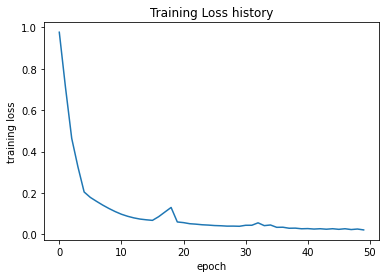

In [41]:
loss_plot(loss_mean)

In [58]:
def predict(x_test, config, attention_net=False):
    device = torch.device("cuda:0" if config.use_cuda and torch.cuda.is_available() else "cpu")
    y_pred = torch.empty((0, len(config.label_columns))).to(device)
    y_hat = []
    test_X = torch.from_numpy(x_test).float()
    test_set = TensorDataset(test_X)
    test_loader = DataLoader(test_set, batch_size=1)

    
    net = Net(config, attention_net).to(device)
    net.load_state_dict(torch.load(config.model_save_path + config.model_name))
    net.eval()
    hidden = None
    for data in test_loader:
        tmp = []
        x = data[0].to(device)
        y, hidden = net.forward(x, hidden)
        hidden = None
#         y_pred_0 = torch.cat((y_pred, y[0]), 0)
        tmp.append(y[0][-1][0].item())
        tmp.append(y[0][-1][1].item())
        y_hat.append(tmp)
    return np.array(y_hat)


def up_down_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result


def evaluate(y_pred, y_test, data_gainer, days=300):
    labels_open = []
    labels_close = []
    for i in range(y_test.shape[0]):
        labels_open.append(y_test[i][0])
    for i in range(y_test.shape[0]):
        labels_close.append(y_test[i][1])
    
    
    
    print("###############################################################")
    print("Evaluation of open price predction on valid set:")
    
    y_pred_0 = y_pred[:,0] * data_gainer.std[0] + data_gainer.mean[0]
    
    
    # Error comptuer of open price prediction
    #Root Mean Square Error
    RMSE = np.sqrt(np.sum((np.array(labels_open) - y_pred_0) ** 2) / len(labels_open)) 
    # Mean Absolute Percentage Error
    MAPE = np.sum((np.array(labels_open) - y_pred_0)/np.array(labels_open))/len(labels_open)*100 
    # Mean Bias Error
    MBE = np.sum((np.array(labels_open) - y_pred_0)) / len(labels_open)
    print("RMSE on validation set is {}".format(RMSE))
    print("MAPE on validation set is {}".format(MAPE))
    print("MBE on validation set is {}".format(MBE))    
    up_down_accu = up_down_accuracy(labels_open, y_pred_0)
    print("Up and down accuracy on validation set is {}%".format(round(up_down_accu*100),2))


    plt.xlabel('Days') 
    plt.ylabel('Price') 
    plt.title('Valid Evaluation of Open prices for 100 days') 
    plt.plot(y_pred_0.tolist()[:days], 'r', label = "predict")
    plt.plot(labels_open[:days], 'b', label = "real")
    plt.legend(loc="upper right")
    plt.show()
    
    
    # Error comptuer of close price prediction

    print("###############################################################")
    print("Evaluation of close price predction on valid set:")
    y_pred_1 = y_pred[:,1] * data_gainer.std[1] + data_gainer.mean[1]
    
    
    # Error comptuer of open price prediction
    # Root Mean Square Error
    RMSE = np.sqrt(np.sum((np.array(labels_close) - y_pred_1) ** 2) / len(labels_close)) 
    # Mean Absolute Percentage Error
    MAPE = np.sum((np.array(labels_close) - y_pred_1)/np.array(labels_close))/len(labels_close)*100 
    # Mean Bias Error
    MBE = np.sum((np.array(labels_close) - y_pred_1)) / len(labels_close)
    print("RMSE on validation set is {}".format(RMSE))
    print("MAPE on validation set is {}".format(MAPE))
    print("MBE on validation set is {}".format(MBE))    
    up_down_accu = up_down_accuracy(labels_close, y_pred_1)
    print("Up and down accuracy on validation set is {}%".format(round(up_down_accu*100),2))


    plt.xlabel('Days') 
    plt.ylabel('Price') 
    plt.title('Valid Evaluation of Close prices for 100 days') 
    plt.plot(y_pred_1.tolist()[:days], 'r', label = "predict close")
    
    
    plt.plot(labels_close[:days], 'b', label = "real close")
    plt.legend(loc="upper right")
    plt.show()


In [43]:
y_pred = predict(valid_x, config)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 85.97545086710555
MAPE on validation set is -1.9114476679128307
MBE on validation set is -54.52895073063665
Up and down accuracy on validation set is 72.0%


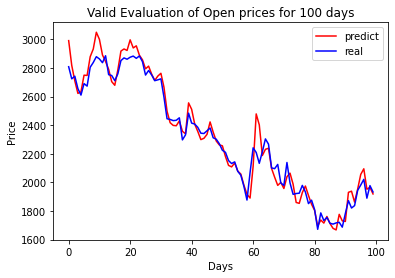

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 90.7685500587805
MAPE on validation set is -1.9600550121299458
MBE on validation set is -55.55819381693256
Up and down accuracy on validation set is 50.0%


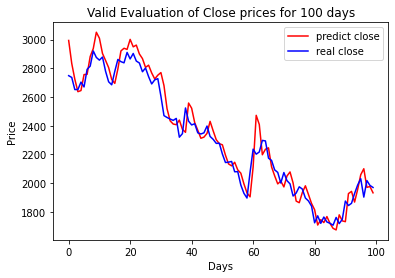

In [44]:
evaluate(y_pred, valid_label, data_gainer)

##Attention layer

In [58]:
_, loss_mean_attention = train(train_x, train_y, config, True)

Start training ...
Epoch 1/50  Train Loss :0.9263387412917036
Epoch 2/50  Train Loss :0.8462696100807569
Epoch 3/50  Train Loss :0.3769305650832882
Epoch 4/50  Train Loss :0.12642144046049678
Epoch 5/50  Train Loss :0.08402148719161137
Epoch 6/50  Train Loss :0.06425671266572577
Epoch 7/50  Train Loss :0.053705822931838905
Epoch 8/50  Train Loss :0.04722694639957496
Epoch 9/50  Train Loss :0.04717387380113186
Epoch 10/50  Train Loss :0.07507693062279262
Epoch 11/50  Train Loss :0.06393458536016379
Epoch 12/50  Train Loss :0.07685150881124132
Epoch 13/50  Train Loss :0.04148747623244773
Epoch 14/50  Train Loss :0.037123759767151814
Epoch 15/50  Train Loss :0.02480956886064456
Epoch 16/50  Train Loss :0.025546627427597265
Epoch 17/50  Train Loss :0.019736358870703505
Epoch 18/50  Train Loss :0.024024295153221423
Epoch 19/50  Train Loss :0.020160749858703964
Epoch 20/50  Train Loss :0.028163530544113757
Epoch 21/50  Train Loss :0.02412214813364753
Epoch 22/50  Train Loss :0.03441808739183

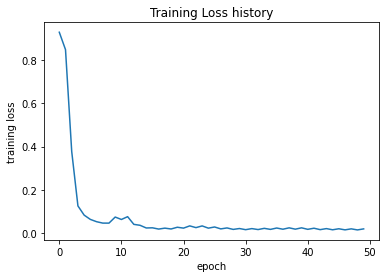

In [59]:
loss_plot(loss_mean_attention)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 153.03903551283886
MAPE on validation set is 0.28654898057013856
MBE on validation set is 14.56832076453811
Up and down accuracy on validation set is 52.0%


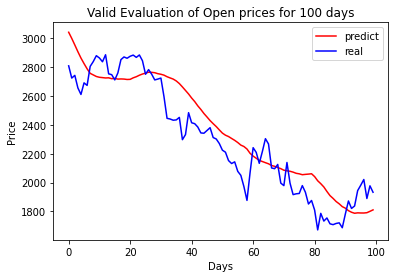

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 154.2358415718926
MAPE on validation set is 0.05735101011187119
MBE on validation set is 8.797825588519828
Up and down accuracy on validation set is 52.0%


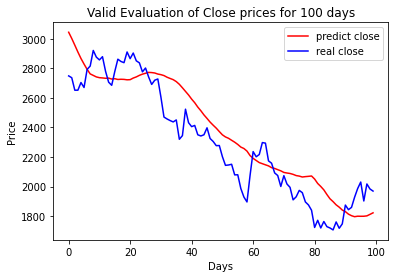

In [60]:
y_pred_attention = predict(valid_x, config, True)
evaluate(y_pred_attention, valid_label, data_gainer)

## 3. Parameter Tuning

Parameter tuning to increase performaces on the valid set

In [59]:
class Config_Tuning():
    def __init__(self, hidden_size=128, time_step=20, lstm_layers=2, learning_rate=0.0001, 
                 epoch=50, batch_size=64, label_columns=[2,3], feature_start=2, feature_end=9,
                 data_path="/content/stock_data.csv"):
        self.data_path = data_path
    
        self.feature_columns = list(range(feature_start, feature_end))  # feature columns' indecies 
        self.label_columns = label_columns                # predicted feature columns' indecies
        self.label_in_feature_index = (lambda x,y: [x.index(i) for i in y])(self.feature_columns, self.label_columns)  
        
        self.predict_day = 1             # predited length (days)
        
        self.input_size = len(self.feature_columns)
        self.output_size = len(self.label_columns)

        self.hidden_size = hidden_size   # hiddent size
        self.lstm_layers = lstm_layers             # stacked layer number
        self.dropout_rate = 0.2          # dropout
        self.time_step = time_step       # step size (day)
        self.epoch = epoch
        self.epoch_attention = 50
        
    #     do_train = True
    #     do_predict = True
    #     shuffle_train_data = True           

        self.train_data_rate = 0.7      
        self.valid_data_rate = 0.15   
        self.test_data_rate = 0.15

        self.batch_size = batch_size
        self.learning_rate = learning_rate

        self.use_cuda = False
        # path
        self.used_frame = "pytorch"
        self.model_name = "model_" + ".pth"
        self.train_data_path = self.data_path
        self.model_save_path = "./checkpoint/" + self.used_frame + "/"
        
    def make_directions(self):
        # save 
        if not os.path.exists(self.model_save_path):
            os.makedirs(self.model_save_path)    

(1) Time Step

In [102]:
config_tuning = Config_Tuning(time_step=20)
config_tuning.make_directions()

Start training ...
Epoch 1/50  Train Loss :0.9167717207403882
Epoch 2/50  Train Loss :0.6785798611731004
Epoch 3/50  Train Loss :0.43928277895632967
Epoch 4/50  Train Loss :0.30268855293197977
Epoch 5/50  Train Loss :0.2025827249380023
Epoch 6/50  Train Loss :0.1781413532418213
Epoch 7/50  Train Loss :0.15927752534122164
Epoch 8/50  Train Loss :0.14163359132275652
Epoch 9/50  Train Loss :0.1250385420063316
Epoch 10/50  Train Loss :0.11005449716571662
Epoch 11/50  Train Loss :0.09694024014509102
Epoch 12/50  Train Loss :0.0858052966720077
Epoch 13/50  Train Loss :0.07749410393064035
Epoch 14/50  Train Loss :0.07179778129724201
Epoch 15/50  Train Loss :0.06703942648913544
Epoch 16/50  Train Loss :0.06457288334243444
Epoch 17/50  Train Loss :0.062104028079714345
Epoch 18/50  Train Loss :0.07711320630024507
Epoch 19/50  Train Loss :0.09234306784416202
Epoch 20/50  Train Loss :0.1139721122618987
Epoch 21/50  Train Loss :0.058310124515764304
Epoch 22/50  Train Loss :0.05463247939096347
Epoch

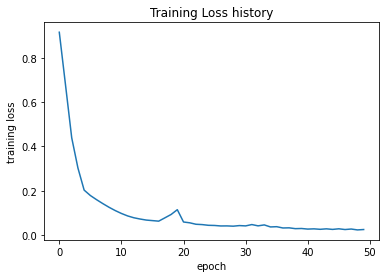

In [103]:
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 63.392382425663
MAPE on validation set is 0.8025668573558513
MBE on validation set is 22.560207618092594
Up and down accuracy on validation set is 71.0%


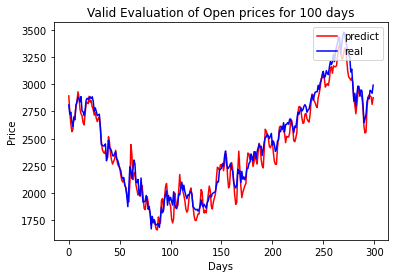

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 66.36876080098331
MAPE on validation set is 0.43384779976364884
MBE on validation set is 12.935367272197004
Up and down accuracy on validation set is 51.0%


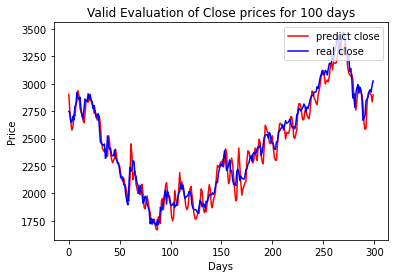

In [104]:
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

(2) Hidden Size

Start training ...
Epoch 1/50  Train Loss :0.9612394010634231
Epoch 2/50  Train Loss :0.78887537832775
Epoch 3/50  Train Loss :0.5557241737564553
Epoch 4/50  Train Loss :0.427573214792438
Epoch 5/50  Train Loss :0.3016888257811096
Epoch 6/50  Train Loss :0.22045601388689742
Epoch 7/50  Train Loss :0.18601038216599333
Epoch 8/50  Train Loss :0.16470140039767903
Epoch 9/50  Train Loss :0.14877658585475675
Epoch 10/50  Train Loss :0.13494459532701703
Epoch 11/50  Train Loss :0.12186536766282881
Epoch 12/50  Train Loss :0.11036159301788281
Epoch 13/50  Train Loss :0.09959927163392639
Epoch 14/50  Train Loss :0.09066811566060382
Epoch 15/50  Train Loss :0.08291154908044125
Epoch 16/50  Train Loss :0.07660554646194648
Epoch 17/50  Train Loss :0.07186855448048506
Epoch 18/50  Train Loss :0.06776058213062473
Epoch 19/50  Train Loss :0.06516839282712274
Epoch 20/50  Train Loss :0.06290389141137365
Epoch 21/50  Train Loss :0.07217990762011996
Epoch 22/50  Train Loss :0.0808793034807626
Epoch 23/

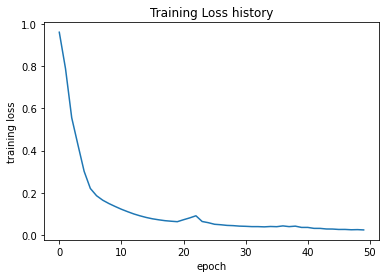

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 57.132328806230824
MAPE on validation set is -0.32160331974445344
MBE on validation set is -10.242381059638415
Up and down accuracy on validation set is 70.0%


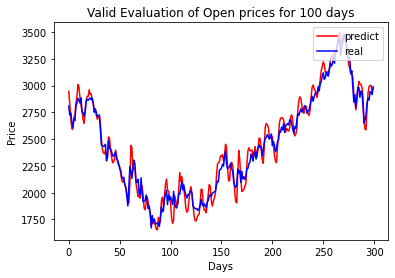

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 69.92060797832153
MAPE on validation set is -0.045362660159392
MBE on validation set is -3.1300290559887896
Up and down accuracy on validation set is 51.0%


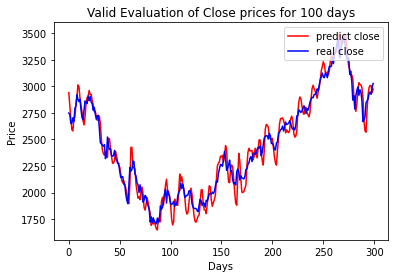

In [109]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20)
config_tuning.make_directions()
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

(3) LSTM Layers

Start training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1/50  Train Loss :0.894126053009905
Epoch 2/50  Train Loss :0.7327250881162264
Epoch 3/50  Train Loss :0.5640809139473113
Epoch 4/50  Train Loss :0.42438439336786077
Epoch 5/50  Train Loss :0.3463936491327277
Epoch 6/50  Train Loss :0.27985035813649867
Epoch 7/50  Train Loss :0.21513929476947594
Epoch 8/50  Train Loss :0.1655504457451014
Epoch 9/50  Train Loss :0.1384185728644813
Epoch 10/50  Train Loss :0.12306902580720776
Epoch 11/50  Train Loss :0.11109019555637974
Epoch 12/50  Train Loss :0.10034319039941557
Epoch 13/50  Train Loss :0.09053490261561167
Epoch 14/50  Train Loss :0.08173318456774994
Epoch 15/50  Train Loss :0.07404408662288046
Epoch 16/50  Train Loss :0.06755615119759772
Epoch 17/50  Train Loss :0.062295748242316075
Epoch 18/50  Train Loss :0.058164568895946685
Epoch 19/50  Train Loss :0.05492557876625223
Epoch 20/50  Train Loss :0.05228876544913249
Epoch 21/50  Train Loss :0.050021721802498975
Epoch 22/50  Train Loss :0.0479855766596356
Epoch 23/50  Train Loss 

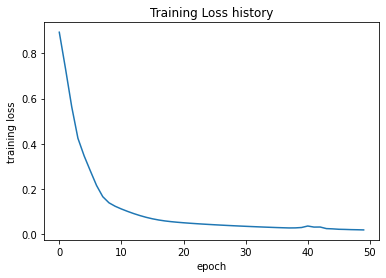

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 53.62326278114571
MAPE on validation set is -0.22293331704000616
MBE on validation set is -5.452154660964707
Up and down accuracy on validation set is 75.0%


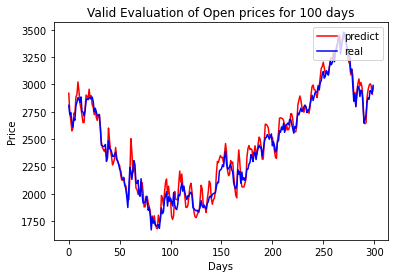

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 65.75106939354319
MAPE on validation set is 0.06275423859263775
MBE on validation set is 2.070380684561442
Up and down accuracy on validation set is 52.0%


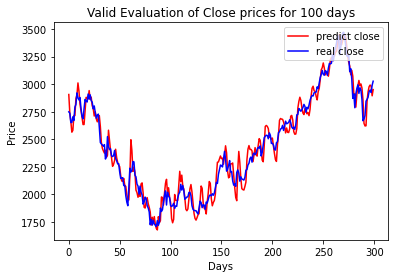

In [115]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=1)
config_tuning.make_directions()
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

(4) Learning Rate

Start training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch 1/200  Train Loss :0.966838293097246
Epoch 2/200  Train Loss :0.8904025326204945
Epoch 3/200  Train Loss :0.8151167635458396
Epoch 4/200  Train Loss :0.7308654051982978
Epoch 5/200  Train Loss :0.6357374341651074
Epoch 6/200  Train Loss :0.5398865567047649
Epoch 7/200  Train Loss :0.46864742743991206
Epoch 8/200  Train Loss :0.4229836951274036
Epoch 9/200  Train Loss :0.3851636309704896
Epoch 10/200  Train Loss :0.3485261385759978
Epoch 11/200  Train Loss :0.31244382925275993
Epoch 12/200  Train Loss :0.2777361367314832
Epoch 13/200  Train Loss :0.2457049704615527
Epoch 14/200  Train Loss :0.21762377919573614
Epoch 15/200  Train Loss :0.19425950861021654
Epoch 16/200  Train Loss :0.17562950235694202
Epoch 17/200  Train Loss :0.1611002516626978
Epoch 18/200  Train Loss :0.14970587117861567
Epoch 19/200  Train Loss :0.14048378341205753
Epoch 20/200  Train Loss :0.13268087421363192
Epoch 21/200  Train Loss :0.12579492701620643
Epoch 22/200  Train Loss :0.11951883203600214
Epoch 23/2

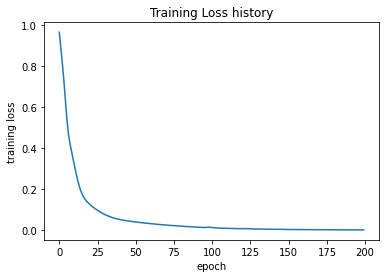

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 35.11736377161197
MAPE on validation set is -0.28497162339068405
MBE on validation set is -7.607077429066519
Up and down accuracy on validation set is 72.0%


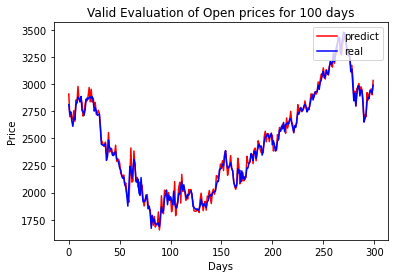

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 59.8128835420665
MAPE on validation set is 0.13351634101920404
MBE on validation set is 4.221399879301978
Up and down accuracy on validation set is 50.0%


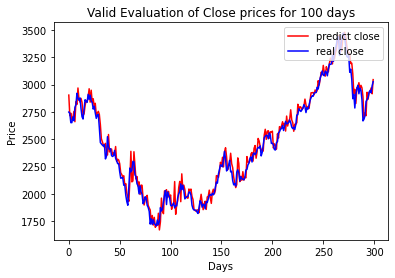

In [24]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=1, learning_rate = 0.00005, epoch=200)
config_tuning.make_directions()
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

Start training ...
Epoch 1/200  Train Loss :1.0344613698491854
Epoch 2/200  Train Loss :0.9483712176695022
Epoch 3/200  Train Loss :0.8207869462724497
Epoch 4/200  Train Loss :0.6214447192597523
Epoch 5/200  Train Loss :0.48497594863787963
Epoch 6/200  Train Loss :0.430587208079202
Epoch 7/200  Train Loss :0.3718145093880594
Epoch 8/200  Train Loss :0.3132100647398785
Epoch 9/200  Train Loss :0.26234831225905403
Epoch 10/200  Train Loss :0.2271078995206574
Epoch 11/200  Train Loss :0.205986753467526
Epoch 12/200  Train Loss :0.19221633165351934
Epoch 13/200  Train Loss :0.1812661382814508
Epoch 14/200  Train Loss :0.1717905276732992
Epoch 15/200  Train Loss :0.16327493733017526
Epoch 16/200  Train Loss :0.15476861999217253
Epoch 17/200  Train Loss :0.14694265936459625
Epoch 18/200  Train Loss :0.13945816493412452
Epoch 19/200  Train Loss :0.13264097331731178
Epoch 20/200  Train Loss :0.1262339830342958
Epoch 21/200  Train Loss :0.12023777343721977
Epoch 22/200  Train Loss :0.1142542364

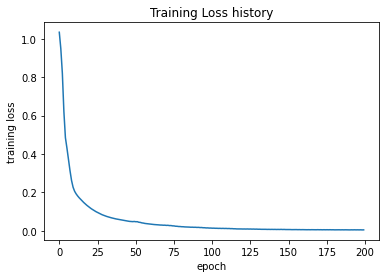

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 38.6180657360773
MAPE on validation set is 0.5805251816933631
MBE on validation set is 15.612339369077832
Up and down accuracy on validation set is 74.0%


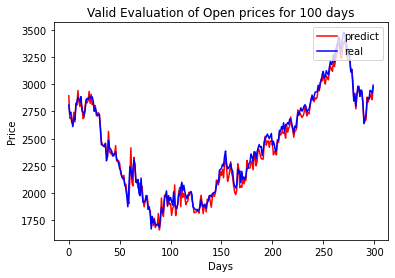

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 51.8883587090582
MAPE on validation set is 0.029575782082407662
MBE on validation set is 0.8003308030109844
Up and down accuracy on validation set is 50.0%


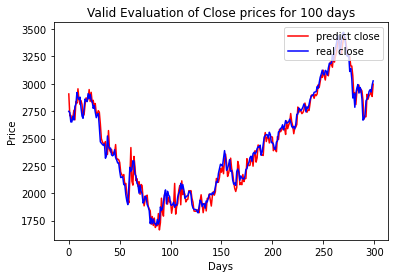

In [60]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, learning_rate = 0.00005, epoch=200)
config_tuning.make_directions()

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 38.6180657360773
MAPE on validation set is 0.5805251816933631
MBE on validation set is 15.612339369077832
Up and down accuracy on validation set is 74.0%


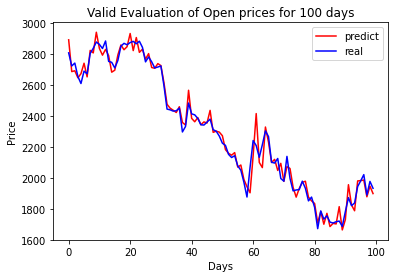

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 51.8883587090582
MAPE on validation set is 0.029575782082407662
MBE on validation set is 0.8003308030109844
Up and down accuracy on validation set is 50.0%


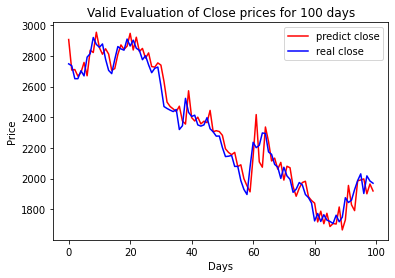

In [61]:
evaluate(y_pred, valid_label, data_gainer, days=100)

(4)* Feature dimension

In [36]:
config_tuning_open = Config_Tuning(hidden_size=32, time_step=20, lstm_layers=2, 
                              learning_rate = 0.01, epoch=100, batch_size=1500, 
                              label_columns=[2], feature_start=2, feature_end=6)
config_tuning_open.make_directions()
data_gainer = Data(config_tuning_open)
train_x, train_y = data_gainer.get_train_data()
valid_x, valid_y = data_gainer.get_valid_data()
test_x= data_gainer.get_test_data()
train_label = data_gainer.return_label("train")
valid_label = data_gainer.return_label("valid")
test_label = data_gainer.return_label("test")

Start training ...
Epoch 1/100  Train Loss :1.071210006872813
Epoch 2/100  Train Loss :0.6117202738920847
Epoch 3/100  Train Loss :0.35368632276852924
Epoch 4/100  Train Loss :0.21895050754149756
Epoch 5/100  Train Loss :0.215257927775383
Epoch 6/100  Train Loss :0.1311748909453551
Epoch 7/100  Train Loss :0.08379337812463443
Epoch 8/100  Train Loss :0.06732999254018068
Epoch 9/100  Train Loss :0.055590792248646416
Epoch 10/100  Train Loss :0.042798303067684174
Epoch 11/100  Train Loss :0.04503016887853543
Epoch 12/100  Train Loss :0.031019122029344242
Epoch 13/100  Train Loss :0.031748037009189524
Epoch 14/100  Train Loss :0.02548229678844412
Epoch 15/100  Train Loss :0.025959656573832035
Epoch 16/100  Train Loss :0.023150190400580566
Epoch 17/100  Train Loss :0.021483473324527342
Epoch 18/100  Train Loss :0.02042645200466116
Epoch 19/100  Train Loss :0.01874700530121724
Epoch 20/100  Train Loss :0.018272438397010166
Epoch 21/100  Train Loss :0.017115518916398287
Epoch 22/100  Train L

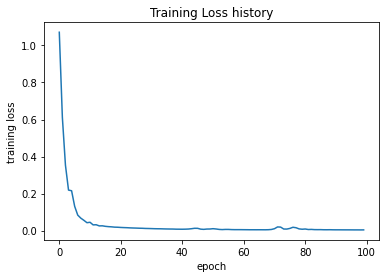

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 45.07432994399194
MAPE on validation set is -1.021631664511673
MBE on validation set is -27.998317001993566
Up and down accuracy on validation set is 67.0%


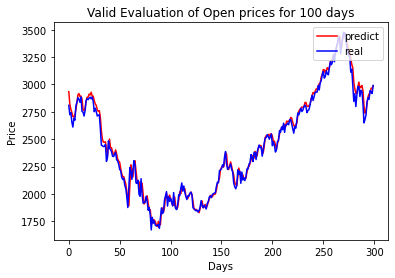

In [37]:
_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 45.07432994399194
MAPE on validation set is -1.021631664511673
MBE on validation set is -27.998317001993566
Up and down accuracy on validation set is 67.0%


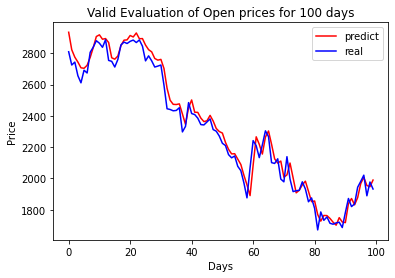

In [38]:
evaluate(y_pred, valid_label, data_gainer, days=100)

(5) Batch Size

Start training ...
Epoch 1/100  Train Loss :0.9872288356224695
Epoch 2/100  Train Loss :0.32357453058163327
Epoch 3/100  Train Loss :0.372546265522639
Epoch 4/100  Train Loss :0.17383245254556337
Epoch 5/100  Train Loss :0.1288460244735082
Epoch 6/100  Train Loss :0.07822952667872111
Epoch 7/100  Train Loss :0.05446843927105268
Epoch 8/100  Train Loss :0.13341486702362695
Epoch 9/100  Train Loss :0.09470149005452792
Epoch 10/100  Train Loss :0.03695235059907039
Epoch 11/100  Train Loss :0.06328323514511187
Epoch 12/100  Train Loss :0.036263827700167894
Epoch 13/100  Train Loss :0.028075874938319128
Epoch 14/100  Train Loss :0.02137705621620019
Epoch 15/100  Train Loss :0.022944043390452862
Epoch 16/100  Train Loss :0.015333259788652262
Epoch 17/100  Train Loss :0.01229362174247702
Epoch 18/100  Train Loss :0.013745766676341495
Epoch 19/100  Train Loss :0.008564189076423645
Epoch 20/100  Train Loss :0.010650804111113151
Epoch 21/100  Train Loss :0.007640244672074914
Epoch 22/100  Train 

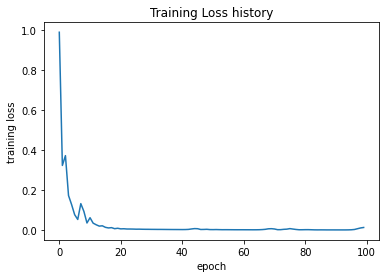

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 50.801971979630665
MAPE on validation set is -0.36646196937343756
MBE on validation set is -10.365639745668156
Up and down accuracy on validation set is 75.0%


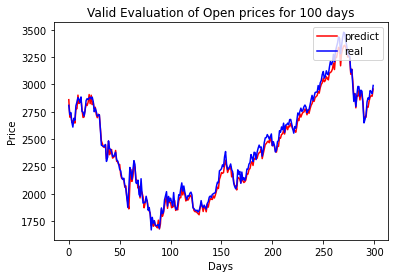

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 60.62823531942233
MAPE on validation set is -0.2550373253555592
MBE on validation set is -7.3230628196793885
Up and down accuracy on validation set is 51.0%


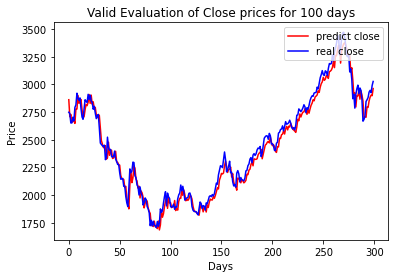

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 50.801971979630665
MAPE on validation set is -0.36646196937343756
MBE on validation set is -10.365639745668156
Up and down accuracy on validation set is 75.0%


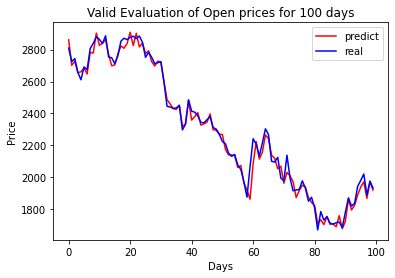

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 60.62823531942233
MAPE on validation set is -0.2550373253555592
MBE on validation set is -7.3230628196793885
Up and down accuracy on validation set is 51.0%


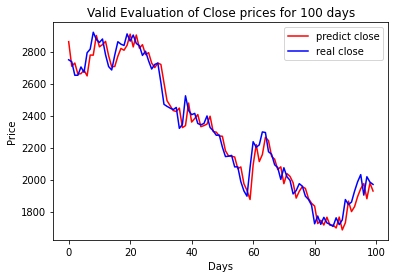

In [64]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, 
                              learning_rate = 0.01, epoch=100, batch_size=1500)
config_tuning.make_directions()

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer)
evaluate(y_pred, valid_label, data_gainer, days=100)

(6) Best Parameters

Start training ...
Epoch 1/200  Train Loss :1.0057247413266728
Epoch 2/200  Train Loss :0.9290980383851078
Epoch 3/200  Train Loss :0.8336722900771272
Epoch 4/200  Train Loss :0.6835160327018864
Epoch 5/200  Train Loss :0.5281023311136819
Epoch 6/200  Train Loss :0.4568375510288708
Epoch 7/200  Train Loss :0.3973877753770507
Epoch 8/200  Train Loss :0.3343856988071617
Epoch 9/200  Train Loss :0.273902292130515
Epoch 10/200  Train Loss :0.22874197662015683
Epoch 11/200  Train Loss :0.20160693163747218
Epoch 12/200  Train Loss :0.18598078624970876
Epoch 13/200  Train Loss :0.1754597166358535
Epoch 14/200  Train Loss :0.16618874704520872
Epoch 15/200  Train Loss :0.15827112007232855
Epoch 16/200  Train Loss :0.15064845907626978
Epoch 17/200  Train Loss :0.14320584659381255
Epoch 18/200  Train Loss :0.1364687992635169
Epoch 19/200  Train Loss :0.12925699254525685
Epoch 20/200  Train Loss :0.12302126381685262
Epoch 21/200  Train Loss :0.11653988726728999
Epoch 22/200  Train Loss :0.11082266

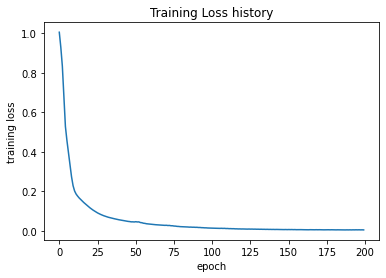

###############################################################
Evaluation of open price predction on valid set:
RMSE on validation set is 33.35272366573018
MAPE on validation set is -0.19942401182502295
MBE on validation set is -6.148726565627647
Up and down accuracy on validation set is 72.0%


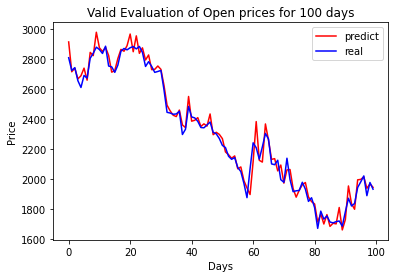

###############################################################
Evaluation of close price predction on valid set:
RMSE on validation set is 58.06006189671377
MAPE on validation set is -0.5524934650252874
MBE on validation set is -15.284570609625442
Up and down accuracy on validation set is 50.0%


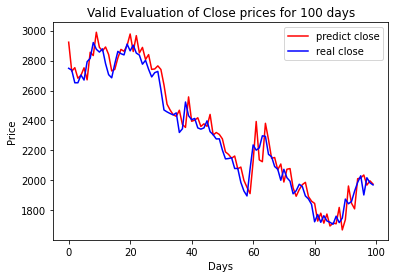

In [66]:
config_tuning = Config_Tuning(hidden_size=100, time_step=20, lstm_layers=2, 
                              learning_rate = 0.00005, epoch=200)
config_tuning.make_directions()

_, tuning_loss_mean = train(train_x, train_y, config_tuning)
loss_plot(tuning_loss_mean)
y_pred = predict(valid_x, config_tuning)
evaluate(y_pred, valid_label, data_gainer, days=100)